# Autoencoders (AE)
We test simple AE with MNIST dataset.

#### (NOTE) The model overview
784 (28x28) dim (x)-> 256 dim (h) -> 2 dim (z)-> 256dim (dh)-> 784 (28x28) dim (y).

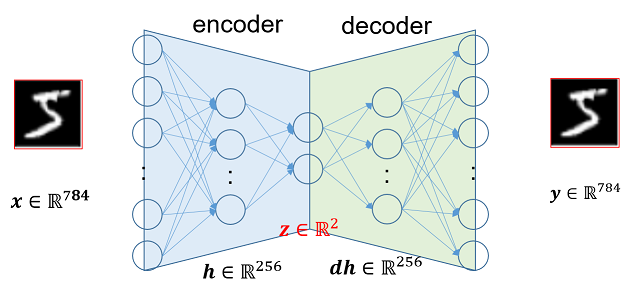

First, we import libraries and define the key parameters.

In [1]:
# import libraries

import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist


In [2]:
# defining the key parameters
batch_size = 100
original_dim = 784 # x: 28x28
latent_dim = 2 # z
intermediate_dim = 256 # h
epochs = 50

In [3]:
print(f'tensorflow version = {tf.__version__}')
print(f'keras version = {keras.__version__}')

# Countermeasures for version inconsistencies
tf.compat.v1.disable_eager_execution()

tensorflow version = 2.3.0
keras version = 2.4.3


### Defining the encoder

In [4]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z = Dense(latent_dim, name="z")(h)

# define and print out summary of the encoder
encoder = Model(x, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoding (Dense)             (None, 256)               200960    
_________________________________________________________________
z (Dense)                    (None, 2)                 514       
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


### Defining the decoder 

In [5]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

# # define and print out summary of the deoder
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


### Definition of the AE
combining the encoder and the decoder

In [6]:
# Combining the encoder and decoder.

output_combined = decoder(encoder(x))
# link the input and the overall output
AE = Model(x, output_combined)
# print out what the overall model looks like
AE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 201474    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________


### Definition of the loss function

Total loss is the binary-cross-entropy (BCE) loss (as a reconstruction error). 

$L_{total}=L_{BCE}$ 

(note) In BCE loss, each pixel value is considered as a probability.

In [7]:
def AE_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor, 
            original_dim=original_dim):
    BCE_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    AE_loss = K.mean(BCE_loss)
    return AE_loss

AE.compile(optimizer='rmsprop', loss=AE_loss)
AE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 201474    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________


### Load MINST dataset 

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


### check the data size and contents

In [10]:
print(f'x_train.shape {x_train.shape}')
print(f'x_test.shape {x_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

x_train.shape (60000, 784)
x_test.shape (10000, 784)
y_train.shape (60000,)
y_test.shape (10000,)


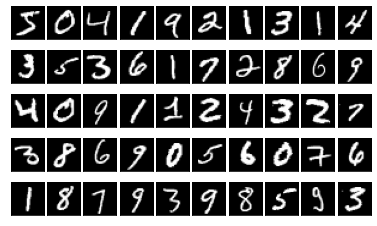

y_train=[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3]


In [11]:
# display MNIST data
W = 10  # number of images in width
H = 5   # number of images in height
fig = plt.figure(figsize=(H, W))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.3, hspace=0.10, wspace=0.10)
for i in range(W*H):
    ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape(28,-1), cmap='gray')

plt.show()
#print(F'x_train {x_train[0:10][0:10]}')
print(F'y_train={y_train[0:W*H]}')

### Train the AE 
It takes about 5 minutes....

In [12]:
AE.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs, 
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 115us/sample - loss: 177.4997
Epoch 2/50
60000/60000 [==============================] - 7s 116us/sample - loss: 159.9937
Epoch 3/50
60000/60000 [==============================] - 7s 116us/sample - loss: 156.2859
Epoch 4/50
60000/60000 [==============================] - 7s 115us/sample - loss: 153.7783
Epoch 5/50
60000/60000 [==============================] - 7s 119us/sample - loss: 151.9796
Epoch 6/50
60000/60000 [==============================] - 7s 117us/sample - loss: 150.5964
Epoch 7/50
60000/60000 [==============================] - 7s 118us/sample - loss: 149.5488
Epoch 8/50
60000/60000 [==============================] - 7s 116us/sample - loss: 148.6514
Epoch 9/50
60000/60000 [==============================] - 7s 117us/sample - loss: 147.9159
Epoch 10/50
60000/60000 [==============================] - 7s 116us/sample - loss: 147.2666
Epoch 11/50
60000/60000 [==============================] - 7s 118u

### Check the distribution of x_test in the latent feature space (z: 2dim)
We can see the distibution of 2D embedding (z).\
 We can see that the same numbers are distributed close together.

### 784dim of the input information is compressed to only 2dim!

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


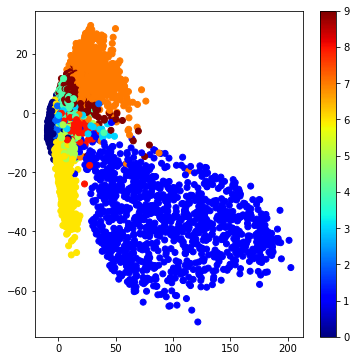

In [13]:
# display a 2D plot of the digit classes in the latent space (first 2dim)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

### Let us see the reconstructed images from the latent space

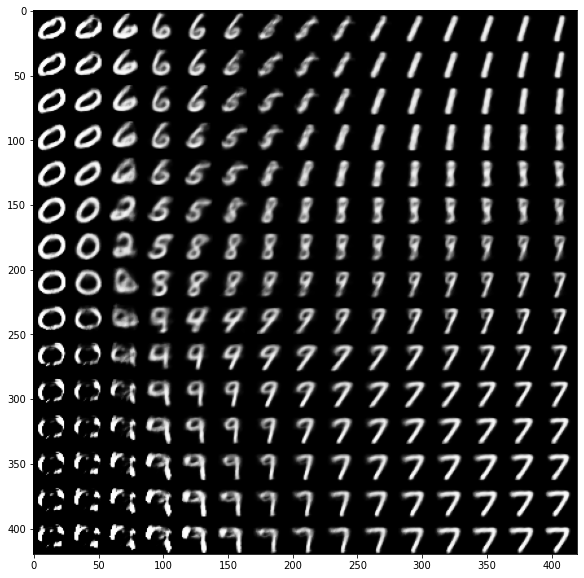

In [16]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# change the range of visialization according to the above results. 
grid_y = np.linspace(-10, 50, n)
grid_x = np.linspace(-20, 20, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()